In [1]:
from LNN import *

import h5py 
import os

# matplotlib settings
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 8, # fontsize for x and y labels (was 10)
    'axes.titlesize': 8,
    'font.size': 8, # was 10
    'legend.fontsize': 6, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update(params)
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

colors = ['#377eb8', '#ff7f00', '#4daf4a', 
          '#f781bf', '#a65628', '#984ea3', 
          '#999999', '#e41a1c', '#dede00',
          '#006BA4', '#FF800E', '#ABABAB', 
          '#595959', '#5F9ED1', '#C85200',
          '#898989', '#A2C8EC', '#FFBC79', 
          '#CFCFCF']

In [2]:
base_N = 'mi_results/exp2'
base_sigmaM = 'mi_results/exp3'
base_sigmaC = 'mi_results/exp4'

In [23]:
# first panel
Ns = [8, 10, 12, 14]
results_N = []
for idx, N in enumerate(Ns):
    results_N.append(
        h5py.File(os.path.join(base_N, 'mi_N%s_sigmaM0.5_sigmaC0.5_sigmaS1.0.h5' %N), 'r')['results']
    ) 

# second panel
sigmaMs = [0.1, 0.3, 0.5, 0.7, 0.9]
results_sigmaM = []
for idx, sigmaM in enumerate(sigmaMs):
    results_sigmaM.append(
        h5py.File(os.path.join(base_sigmaM, 'mi_N12_sigmaM%0.1f_sigmaC0.5_sigmaS1.0.h5' %sigmaM), 'r')['results']
    )

# third panel
sigmaCs = [0.1, 0.3, 0.5, 0.7, 0.9]
results_sigmaC = []
for idx, sigmaC in enumerate(sigmaCs):
    results_sigmaC.append(
        h5py.File(os.path.join(base_sigmaC, 'mi_N12_sigmaM0.5_sigmaC%0.1f_sigmaS1.0.h5' %sigmaC), 'r')['results']
    )

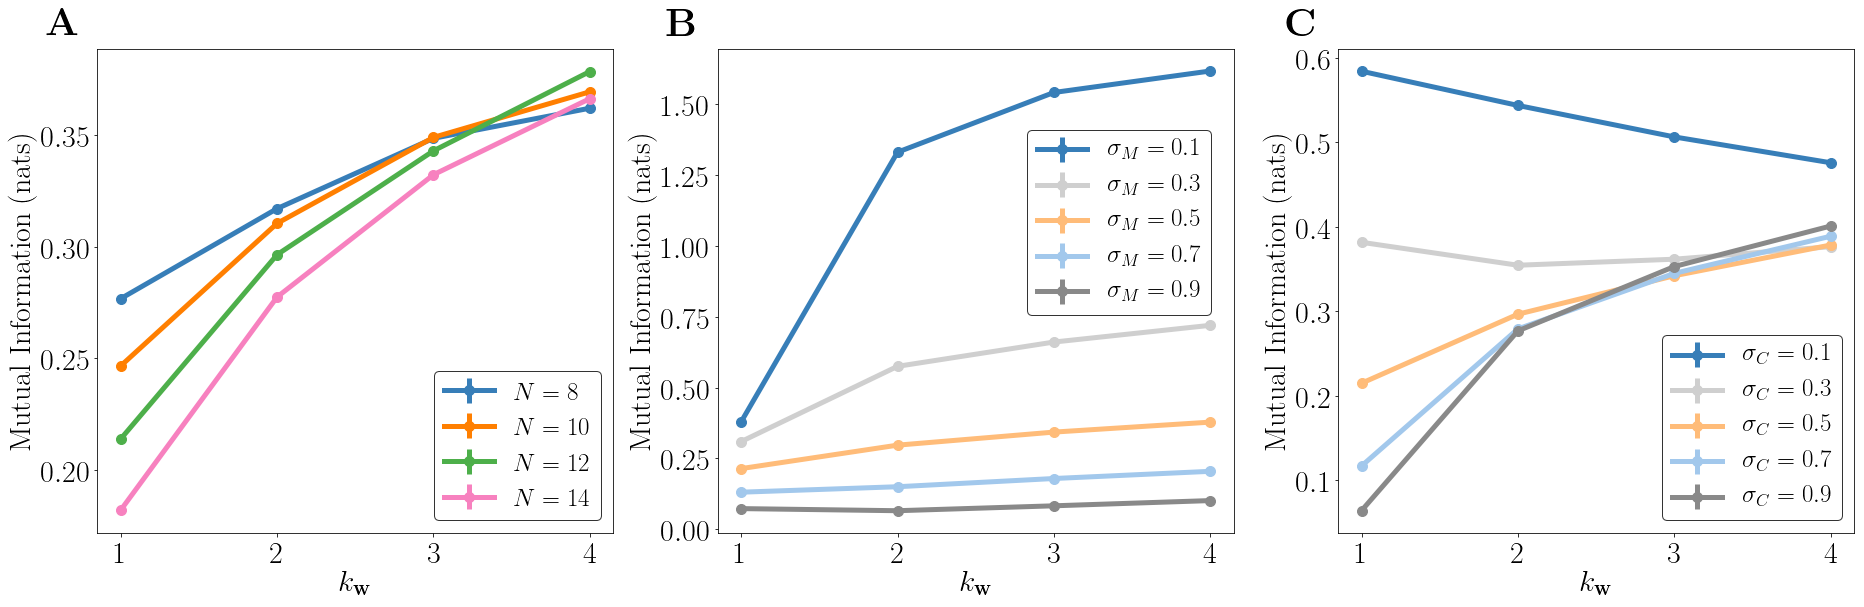

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(26, 8))

# first panel 
for idx, N in enumerate(Ns):
    axes[0].errorbar(
        [1, 2, 3, 4], 
        np.mean(results_N[idx][:, :], axis=1), 
        yerr=np.std(results_N[idx][:, :], axis=1)/10., 
        color=colors[idx], 
        linewidth=5,
        marker='o',
        markersize=10,
        label=r'$N=%s$' %N
    )
    lgd = axes[0].legend(
        prop={'size' : 25}
    )
    lgd.get_frame().set_edgecolor('black')
axes[0].tick_params(labelsize=30)
axes[0].set_xticks([1, 2, 3, 4])
axes[0].set_xlabel(r'$k_{\mathbf{w}}$', fontsize=30)
axes[0].set_ylabel(r'Mutual Information (nats)', fontsize=30)
axes[0].text(x=-0.1, y=1.05, s=r'\textbf{A}', fontsize=40, verticalalignment='center', transform=axes[0].transAxes)

# second panel
for idx, sigmaM in enumerate(sigmaMs):
    axes[1].errorbar(
        [1, 2, 3, 4], 
        np.mean(results_sigmaM[idx][:, :], axis=1), 
        yerr=np.std(results_sigmaM[idx][:, :], axis=1)/10., 
        color=colors[-idx], 
        linewidth=5,
        marker='o',
        markersize=10,
        label=r'$\sigma_M=%s$' %sigmaM
    )
    lgd = axes[1].legend(
        loc=(0.6, 0.45),
        prop={'size' : 25}
    )
    lgd.get_frame().set_edgecolor('black')
axes[1].tick_params(labelsize=30)
axes[1].set_xticks([1, 2, 3, 4])
axes[1].set_xlabel(r'$k_{\mathbf{w}}$', fontsize=30)
axes[1].set_ylabel(r'Mutual Information (nats)', fontsize=30)
axes[1].text(x=-0.1, y=1.05, s=r'\textbf{B}', fontsize=40, verticalalignment='center', transform=axes[1].transAxes)

# third panel
for idx, sigmaC in enumerate(sigmaCs):
    axes[2].errorbar(
        [1, 2, 3, 4], 
        np.mean(results_sigmaC[idx][:, :], axis=1), 
        yerr=np.std(results_sigmaC[idx][:, :], axis=1)/10., 
        color=colors[-idx], 
        linewidth=5,
        marker='o',
        markersize=10,
        label=r'$\sigma_C=%s$' %sigmaC
    )
    lgd = axes[2].legend(
        prop={'size' : 25}
    )
    lgd.get_frame().set_edgecolor('black')
axes[2].tick_params(labelsize=30)
axes[2].set_xticks([1, 2, 3, 4])
axes[2].set_xlabel(r'$k_{\mathbf{w}}$', fontsize=30)
axes[2].set_ylabel(r'Mutual Information (nats)', fontsize=30)
axes[2].text(x=-0.1, y=1.05, s=r'\textbf{C}', fontsize=40, verticalalignment='center', transform=axes[2].transAxes)

plt.tight_layout()
plt.savefig('figure6.pdf', bbox_inches='tight')